# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Is the pipeline functional?
  * Check of output at each stage of pipeline
* simulating 3 isopycnic gradients for both treatment & control  

# Setting variables

In [2]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation_rep3/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

bandwidth = 0.8
DBL_scaling = 0.5
subsample_dist = 'lognormal'
subsample_mean = 9.432
subsample_scale = 0.5
subsample_min = 10000
subsample_max = 30000

# Init

In [3]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome1147/validation_rep3


In [6]:
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_range_BD)
print 'Max BD: {}'.format(max_range_BD)

Min BD: 1.67323
Max BD: 1.7744


# Simulating fragments

In [12]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [13]:
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

In [14]:
!printf "Number of taxa with >=1 amplicon: "
!grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1102


## Number of amplicons per taxon

In [15]:
!grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 338|    o       
 320|    o       
 303|    o       
 285|    o       
 268|    o       
 250|    o       
 232|   oo       
 215|   oo       
 197|   oo       
 180|   oo       
 162|   oo o     
 144|   oo o     
 127|  ooo o     
 109|  ooo o     
  92|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1147     |
|    min value: 0.000000     |
|      mean : 3.823888       |
|    max value: 15.000000    |
------------------------------


# Converting fragments to kde object

In [16]:
!SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [17]:
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [18]:
%%R 
# loading
df = read.delim('ampFrags_kde_info.txt', sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

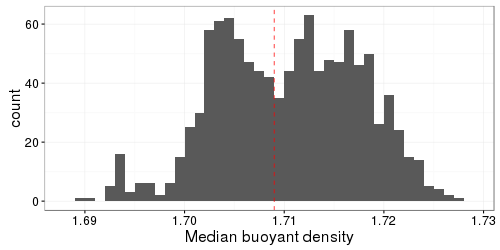

In [19]:
%%R -w 500 -h 250
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Making an incorp config file

* 10% of taxa with 100% atom excess 13C

In [11]:
!SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    --n_reps 3 \
    > PT10_PI100.config
    
# checking output
!cat PT10_PI100.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
        
        [[[end]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
[2]
    # 'treatment' community: possible incorporation
    treatment = labeled
    max_perc_taxa_incorp = 10
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            [[[[interPopDist 1]]]]
                start = 100
                distribution = uniform
                end = 100
        
        [[[end]]]
            [[[[interPopDist 1]]]]
                start = 100
                distribution = uniform
                end = 100
    

[3]
    # baseline: no incorporation
    treatment = control
 

# Selecting incorporator taxa

* This is to make the gradient replicates consistent (qSIP finds mean among replicates)

In [20]:
!SIPSim KDE_selectTaxa \
    -f 0.1 \
    ampFrags_kde.pkl \
    > incorporators.txt

Loading KDEs...
Subsampled 114 taxa


# Creating a community file

* 2 communities
  * control vs treatment

In [53]:
!SIPSim communities \
    --config PT10_PI100.config \
    $genomeDir/genome_index.txt \
    > comm.txt

## Plotting community rank abundances

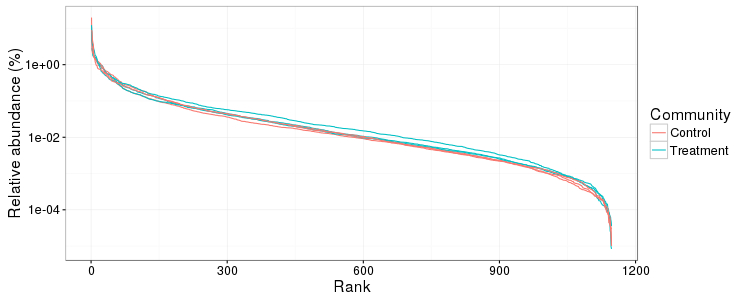

In [59]:
%%R -w 750 -h 300


tbl = read.delim('comm.txt', sep='\t') %>%
    mutate(library = library %>% as.character %>% as.numeric,
           condition = ifelse(library %% 2 == 0, 'Control', 'Treatment'))

ggplot(tbl, aes(rank, rel_abund_perc, color=condition, group=library)) +
    geom_line() +
    scale_y_log10() +
    scale_color_discrete('Community') +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating gradient fractions

In [60]:
!SIPSim gradient_fractions \
    --BD_min $min_range_BD \
    --BD_max $max_range_BD \
    comm.txt \
    > fracs.txt    

## Plotting fractions

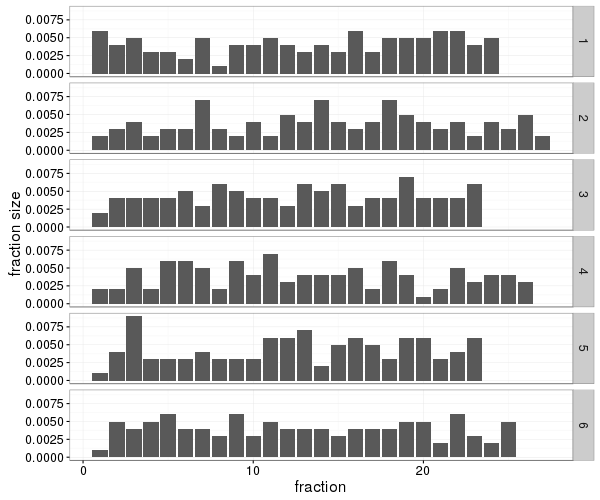

In [61]:
%%R -w 600 -h 500

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

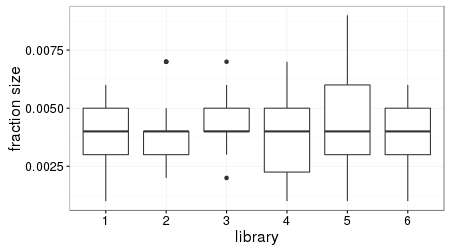

In [62]:
%%R -w 450 -h 250
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Adding diffusion

In [63]:
!SIPSim diffusion \
    --bw $bandwidth \
    --np 20 \
    ampFrags_kde.pkl \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'contamination'

* DBL = diffusive boundary layer

In [64]:
!SIPSim DBL \
    --comm comm.txt \
    --commx $DBL_scaling \
    --np 20 \
    ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_DBL.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!tail -n 5 ampFrags_kde_dif_DBL.log

Processing: Dyadobacter_fermentans_DSM_18053
Processing: Oscillatoria_acuminata_PCC_6304
Processing: Ruminococcus_albus_7_DSM_20455
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Mycobacterium_africanum_GM041182


## Comparing DBL+diffusion to diffusion

In [65]:
# none
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [66]:
%%R 

inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'raw'

inFile = 'ampFrags_kde_dif_info.txt'
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'

inFile = 'ampFrags_kde_dif_DBL_info.txt'
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID        min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1   1.706522     1.707276
2      1 Tropheryma_whipplei_str_Twist      2 378.000000  4124.950000
3      1   Caldisericum_exile_AZM16c01    NaN        NaN          NaN
  percentile_25        mean      median percentile_75 percentile_95
1      1.708229    1.709685    1.709804       1.71067      1.712655
2   6126.750000 7053.396500 7318.000000    8217.00000   9092.050000
3           NaN         NaN         NaN           NaN           NaN
           max        stdev stage
1     1.718852 1.635745e-03   raw
2 10774.000000 1.534612e+03   raw
3          NaN          NaN   raw


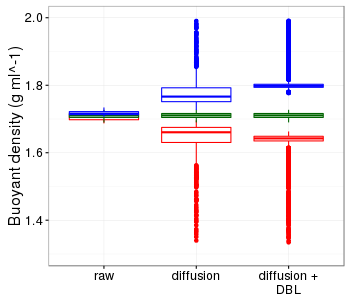

In [67]:
%%R -w 350 -h 300

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Adding isotope incorporation to BD distribution

In [77]:
!SIPSim isotope_incorp \
    --comm comm.txt \
    --shift ampFrags_BD-shift.txt \
    --taxa incorporators.txt \
    --np 18 \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    > ampFrags_kde_dif_DBL_incorp.pkl \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking log
!tail -n 5 ampFrags_kde_dif_DBL_incorp.log

^C
    self._callback(*self._args, **self._kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/processing/pool.py", line 307, in _terminatePool
    inqueue._rlock.acquire()
KeyboardInterrupt
Exception TypeError: TypeError("'NoneType' object does not support item deletion",) in <Finalize object, dead> ignored


# Plotting stats on BD shift from isotope incorporation

In [81]:
%%R
inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

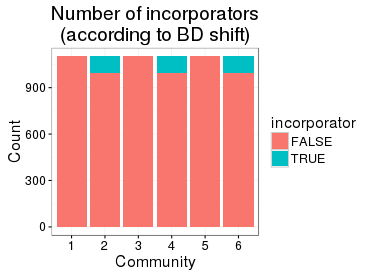

In [99]:
%%R -h 275 -w 375

inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character %>% as.numeric)

df.s = df %>% 
    mutate(incorporator = ifelse(min > 0.001, TRUE, FALSE),
           incorporator = ifelse(is.na(incorporator), 'NA', incorporator),
           condition = ifelse(library %% 2 == 0, 'control', 'treatment')) %>%
    group_by(library, incorporator, condition) %>%
    summarize(n_incorps = n())


# plotting
ggplot(df.s, aes(library %>% as.character, n_incorps, fill=incorporator)) +
    geom_bar(stat='identity') +
    labs(x='Community', y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Simulating an OTU table

In [100]:
!SIPSim OTU_table \
    --abs 1e9 \
    --np 20 \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!tail -n 5 OTU_n2_abs1e9.log 

   taxon abs-abundance:  9461284
  Processing taxon: "Chlamydophila_caviae_GPIC"
   taxon abs-abundance:  8301053
  Processing taxon: "Chloroflexus_aurantiacus_J-10-fl"
   taxon abs-abundance:  7834655


## Plotting taxon abundances

In [101]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

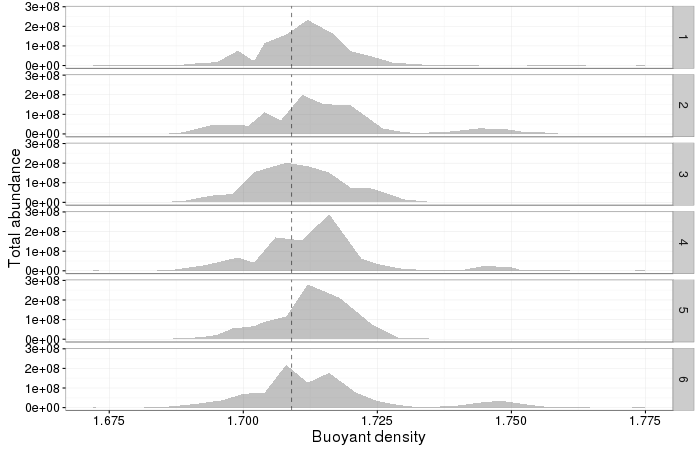

In [117]:
%%R -w 700 -h 450
# plotting absolute abundances

# loading file
df = read.delim('OTU_n2_abs1e9.txt', sep='\t') 

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

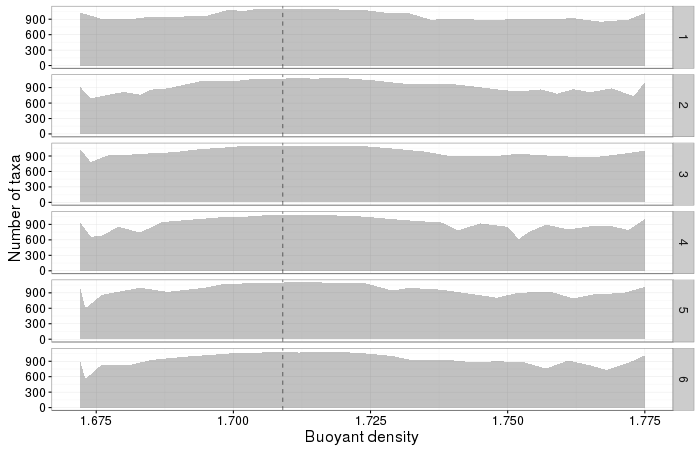

In [118]:
%%R -w 700 -h 450
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

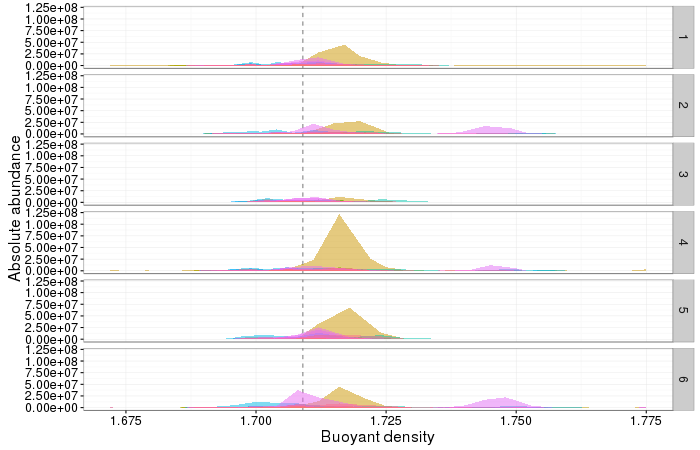

In [119]:
%%R -w 700 -h 450
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

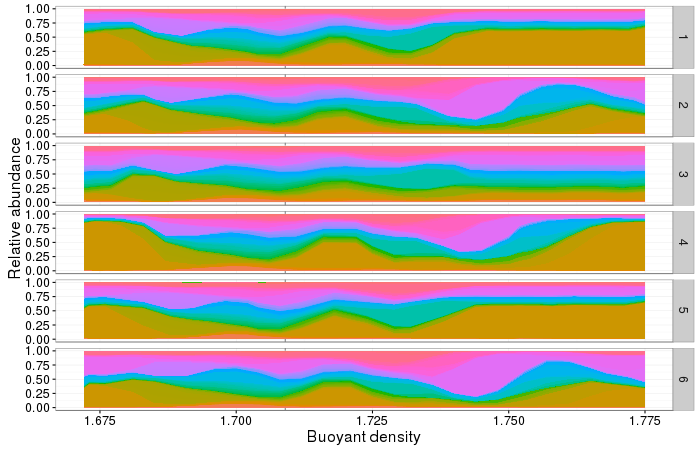

In [120]:
%%R -w 700 -h 450
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Simulating PCR bias

In [123]:
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

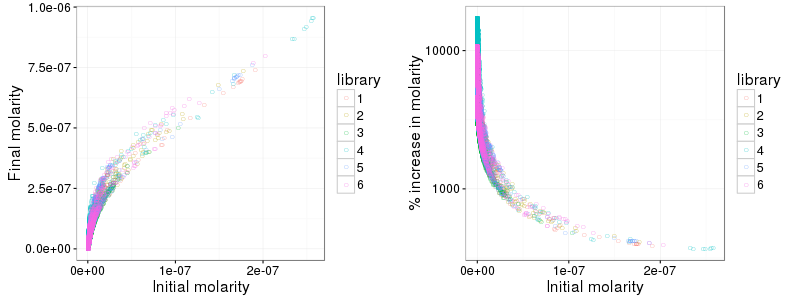

In [125]:
%%R -w 800 -h 300
# loading file
F = 'OTU_n2_abs1e9_PCR.txt'
df.SIM = read.delim(F, sep='\t') %>%
    mutate(molarity_increase = final_molarity / init_molarity * 100,
           library = library %>% as.character)

p1 = ggplot(df.SIM, aes(init_molarity, final_molarity, color=library)) +
    geom_point(shape='O', alpha=0.5) +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(init_molarity, molarity_increase, color=library)) +
    geom_point(shape='O', alpha=0.5) +
    scale_y_log10() +
    labs(x='Initial molarity', y='% increase in molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=2)

In [126]:
# PCR w/out --debug (no extra output)
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_PCR.txt

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [110]:
!SIPSim OTU_subsample \
    --dist $subsample_dist \
    --dist_params mean:$subsample_mean,sigma:$subsample_scale \
    --min_size $subsample_min \
    --max_size $subsample_max \
    OTU_n2_abs1e9_PCR.txt \
    > OTU_n2_abs1e9_PCR_subNorm.txt

### Plotting seq count distribution

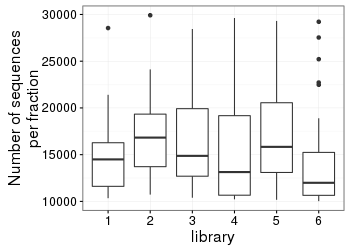

In [127]:
%%R -w 350 -h 250

df = read.csv('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    labs(y='Number of sequences\nper fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions 

In [133]:
%%R 

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

#lib.reval = c('1' = 'control',
#              '2' = 'treatment',
#              '3' = 'control',
#              '4' = 'treatment',
#              '5' = 'control',
#              '6' = 'treatment')

#df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
#df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

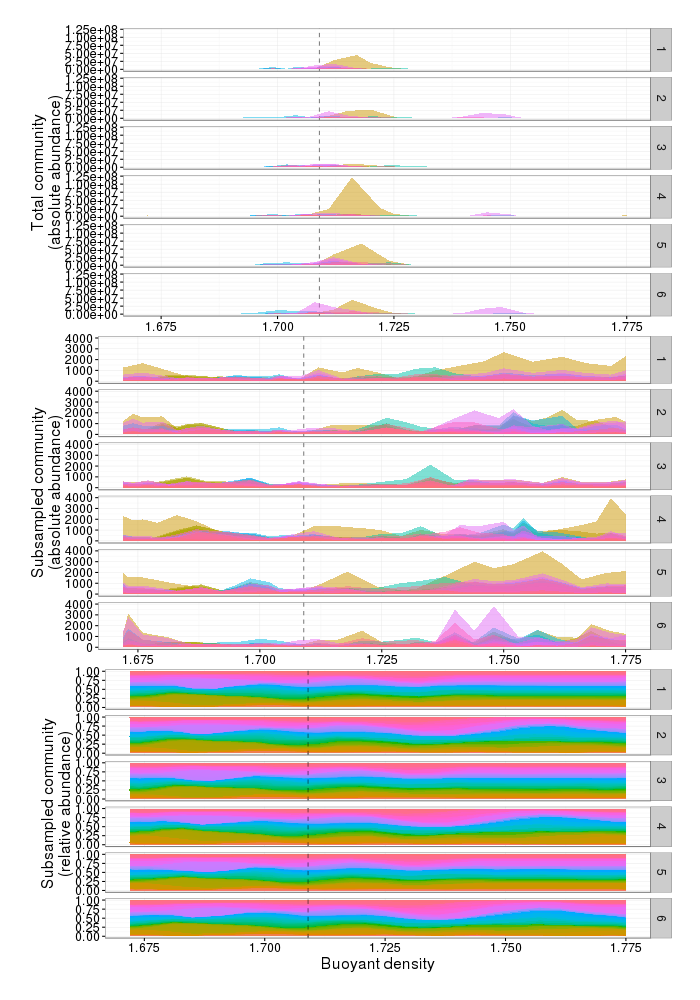

In [134]:
%%R -w 700 -h 1000
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

# Making a wide OTU table

In [114]:
!SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [130]:
!SIPSim OTU_sampleData \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_meta.txt

/home/nick/notebook/SIPSim/bin/OTU_sampleData.py:52: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df[['BD_min','BD_max']] = df['fraction'].str.extract('(.+)-(.+)')


# Community analysis

## Phyloseq

In [136]:
# making phyloseq object from OTU table
!SIPSimR phyloseq_make \
    OTU_n2_abs1e9_PCR_subNorm_w.txt \
    -s OTU_n2_abs1e9_PCR_subNorm_meta.txt \
    > OTU_n2_abs1e9_PCR_subNorm.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf    

## filtering phyloseq object to just taxa/samples of interest (eg., BD-min/max)
!SIPSimR phyloseq_edit \
    --BD_min 1.71 \
    --BD_max 1.75 \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_filt.physeq

## making ordination
!SIPSimR phyloseq_ordination \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf
    
# making png figures
!convert OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png
!convert OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.09771841 
Run 1 stress 0.09771842 
... procrustes: rmse 6.866795e-06  max resid 6.250731e-05 
*** Solution reached
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 6 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 6 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
pre-filter: number of samples:160
pre-filter: number of taxa:1147
post-filter: number of samples:5

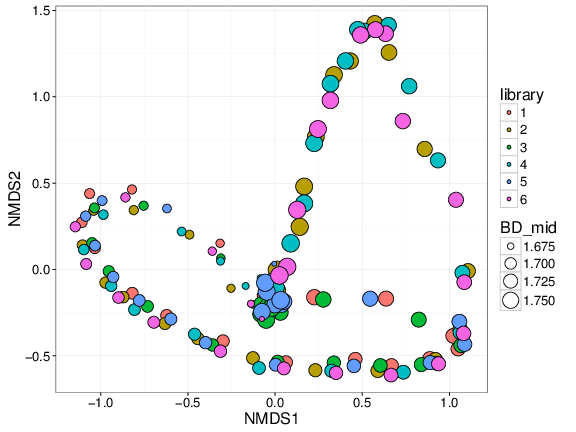

In [137]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png') 

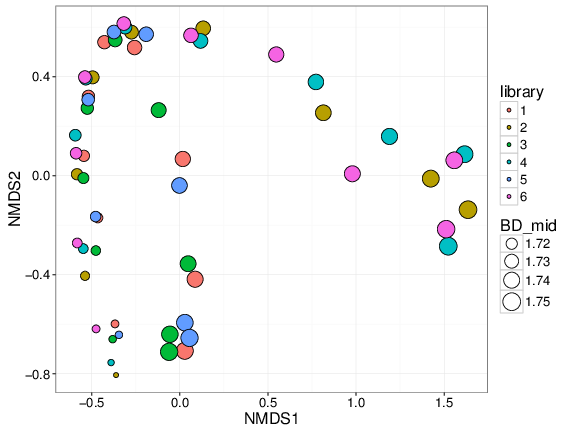

In [138]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png')

## DESeq2

In [155]:
## DESeq2
!SIPSimR phyloseq_DESeq2 \
    --log2 0.25 \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    > OTU_n2_abs1e9_PCR_subNorm_DESeq2
    
## Confusion matrix
!SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj 0.1 \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_DESeq2

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 5 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx
File written: DESeq2-cMtx_data.txt
File written: DESeq2-cMtx_table.txt
File written: DESeq2-cMtx_overall.txt
File written: DESeq2-cMtx_byClass.txt


  library         variables  values
1       2 Balanced Accuracy 0.90625
2       4 Balanced Accuracy 0.90625
3       6 Balanced Accuracy 0.90625


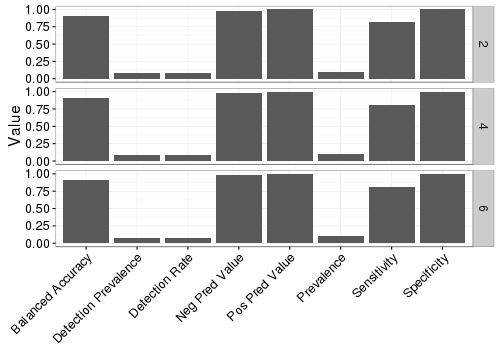

In [163]:
%%R -w 500 -h 350

byClass = read.delim('DESeq2-cMtx_byClass.txt', sep='\t') 

byClass %>% filter(variables=='Balanced Accuracy') %>% print

ggplot(byClass, aes(variables, values)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

## Plotting results of DESeq2

In [159]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [160]:
%%R 

df = read.delim('DESeq2-cMtx_data.txt', sep='\t')

df = df %>%
    filter(! is.na(log2FoldChange), library %in% c(2,4,6)) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  library                                taxon   min   q25  mean median   q75
1       2       Acaryochloris_marina_MBIC11017 0.036 0.036 0.036  0.036 0.036
2       2 Acetobacter_pasteurianus_IFO_3283-03 0.000 0.000 0.000  0.000 0.000
3       2       Acetobacterium_woodii_DSM_1030 0.000 0.000 0.000  0.000 0.000
    max  baseMean log2FoldChange     lfcSE     stat       pvalue         padj
1 0.036 82.741341      6.0318969 0.9183703 6.295823 1.528866e-10 3.329531e-09
2 0.000  0.474078     -0.4161446 0.7808848 0.000000 8.031881e-01 1.000000e+00
3 0.000  1.011527     -1.2198146 0.6520957 0.000000 9.879015e-01 1.000000e+00
             p      padj.BH incorp.known incorp.pred           cls
1 1.528866e-10 3.329531e-09         TRUE        TRUE True positive
2 8.031881e-01 1.000000e+00        FALSE       FALSE True negative
3 9.879015e-01 1.000000e+00        FALSE       FALSE True negative


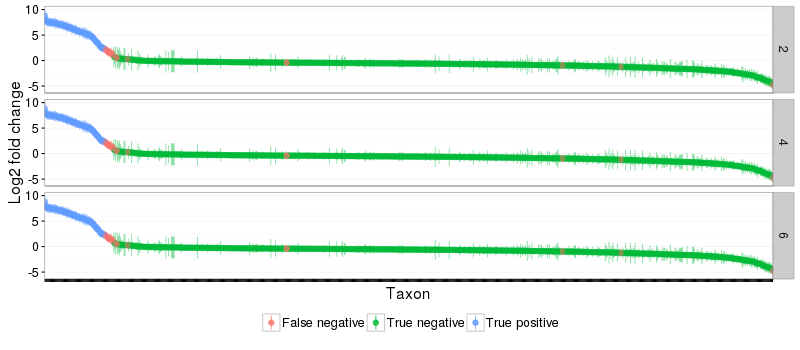

In [161]:
%%R -w 800 -h 350

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, 
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.4, alpha=0.5) +
    geom_pointrange(data=df.TP, size=0.4, alpha=0.3) +
    geom_pointrange(data=df.FP, size=0.4, alpha=0.3) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )